In [1]:
#######################################################################################################
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import sys

# Get the current notebook's directory
notebook_dir = os.path.abspath('')
# Add the relative path to your Codes directory
codes_path = os.path.join(notebook_dir, "..", "Codes")
codes_path = os.path.abspath(codes_path)  # Normalize the path
# Add to path if not already there
if codes_path not in sys.path:
    sys.path.insert(1, codes_path)
from myUtils import *

MAINPATH is set to: /home/emanuele/Research/APES/FHN/


In [2]:
# World shapefile
shapef = os.path.join(MAINPATH, 'Data/SHAPEFILES/world-administrative-boundaries.shp')
gdf = gpd.read_file(shapef)
gdf = gdf.to_crs("ESRI:54009")

# Custom regions shapefiles 
shapef = os.path.join(MAINPATH, 'Data/SHAPEFILES/world-custom_regions_r.shp')
gdf1 = gpd.read_file(shapef)
gdf1 = gdf1.to_crs("ESRI:54009")

In [5]:
REGIONS = gdf1['custom_reg']

In [6]:
fName =  os.path.join(MAINPATH, 'Data/POPULATION/population_50_2020_v5.tif')
src = rasterio.open(fName)
fName =  os.path.join(MAINPATH, 'Data/LANDUSE/Forest/forest_50_2020.tif')
src1 = rasterio.open(fName)

In [27]:
# Preallocate lists
pop_vals = []
forest_vals = []
regions = []

# Process each region
for region in gdf1.itertuples(index=False):
    geom = [region.geometry]

    # Population
    pop_data, _ = mask(src, geom, crop=True)
    pop_sum = np.nansum(pop_data)
    pop_vals.append(pop_sum)

    # Forest
    forest_data, _ = mask(src1, geom, crop=True)
    forest_sum = np.nansum(forest_data)
    forest_vals.append(forest_sum)

    # Save region
    regions.append(region.custom_reg)

# Create DataFrame once
dff = pd.DataFrame({
    'forest': forest_vals,
    'pop': pop_vals,
    'FAP': np.array(forest_vals) / np.array(pop_vals),
    'region': regions
})
dff['FAPh'] = dff['FAP'] * 100
dff

,forest,pop,FAP,region,FAPh
0,117518.0,7.519806e+07,0.001563,Central Asia,0.156278
1,1943434.0,4.240659e+08,0.004583,Eastern Africa,0.458286
2,2610974.0,1.571840e+09,0.001661,Eastern Asia,0.166109
3,8819693.0,2.888339e+08,0.030536,Eastern Europe,3.053552
4,3116872.0,1.918344e+08,0.016248,Middle Africa,1.624773
5,224601.0,2.303826e+08,0.000975,Northern Africa,0.097490
6,7761885.0,5.581046e+08,0.013908,Northern America,1.390758
7,746522.0,9.248606e+07,0.008072,Northern Europe,0.807172
8,1633942.0,3.206077e+07,0.050964,Oceania,5.096391
9,8455389.0,3.877063e+08,0.021809,South America,2.180875


In [28]:
dff = dff.sort_values(by='FAPh').reset_index(drop=True)
colors = dff['region'].map(REGION_TO_CONTINENT).map(CONTINENT_COLORS)

(0.037811546007742204, 10)

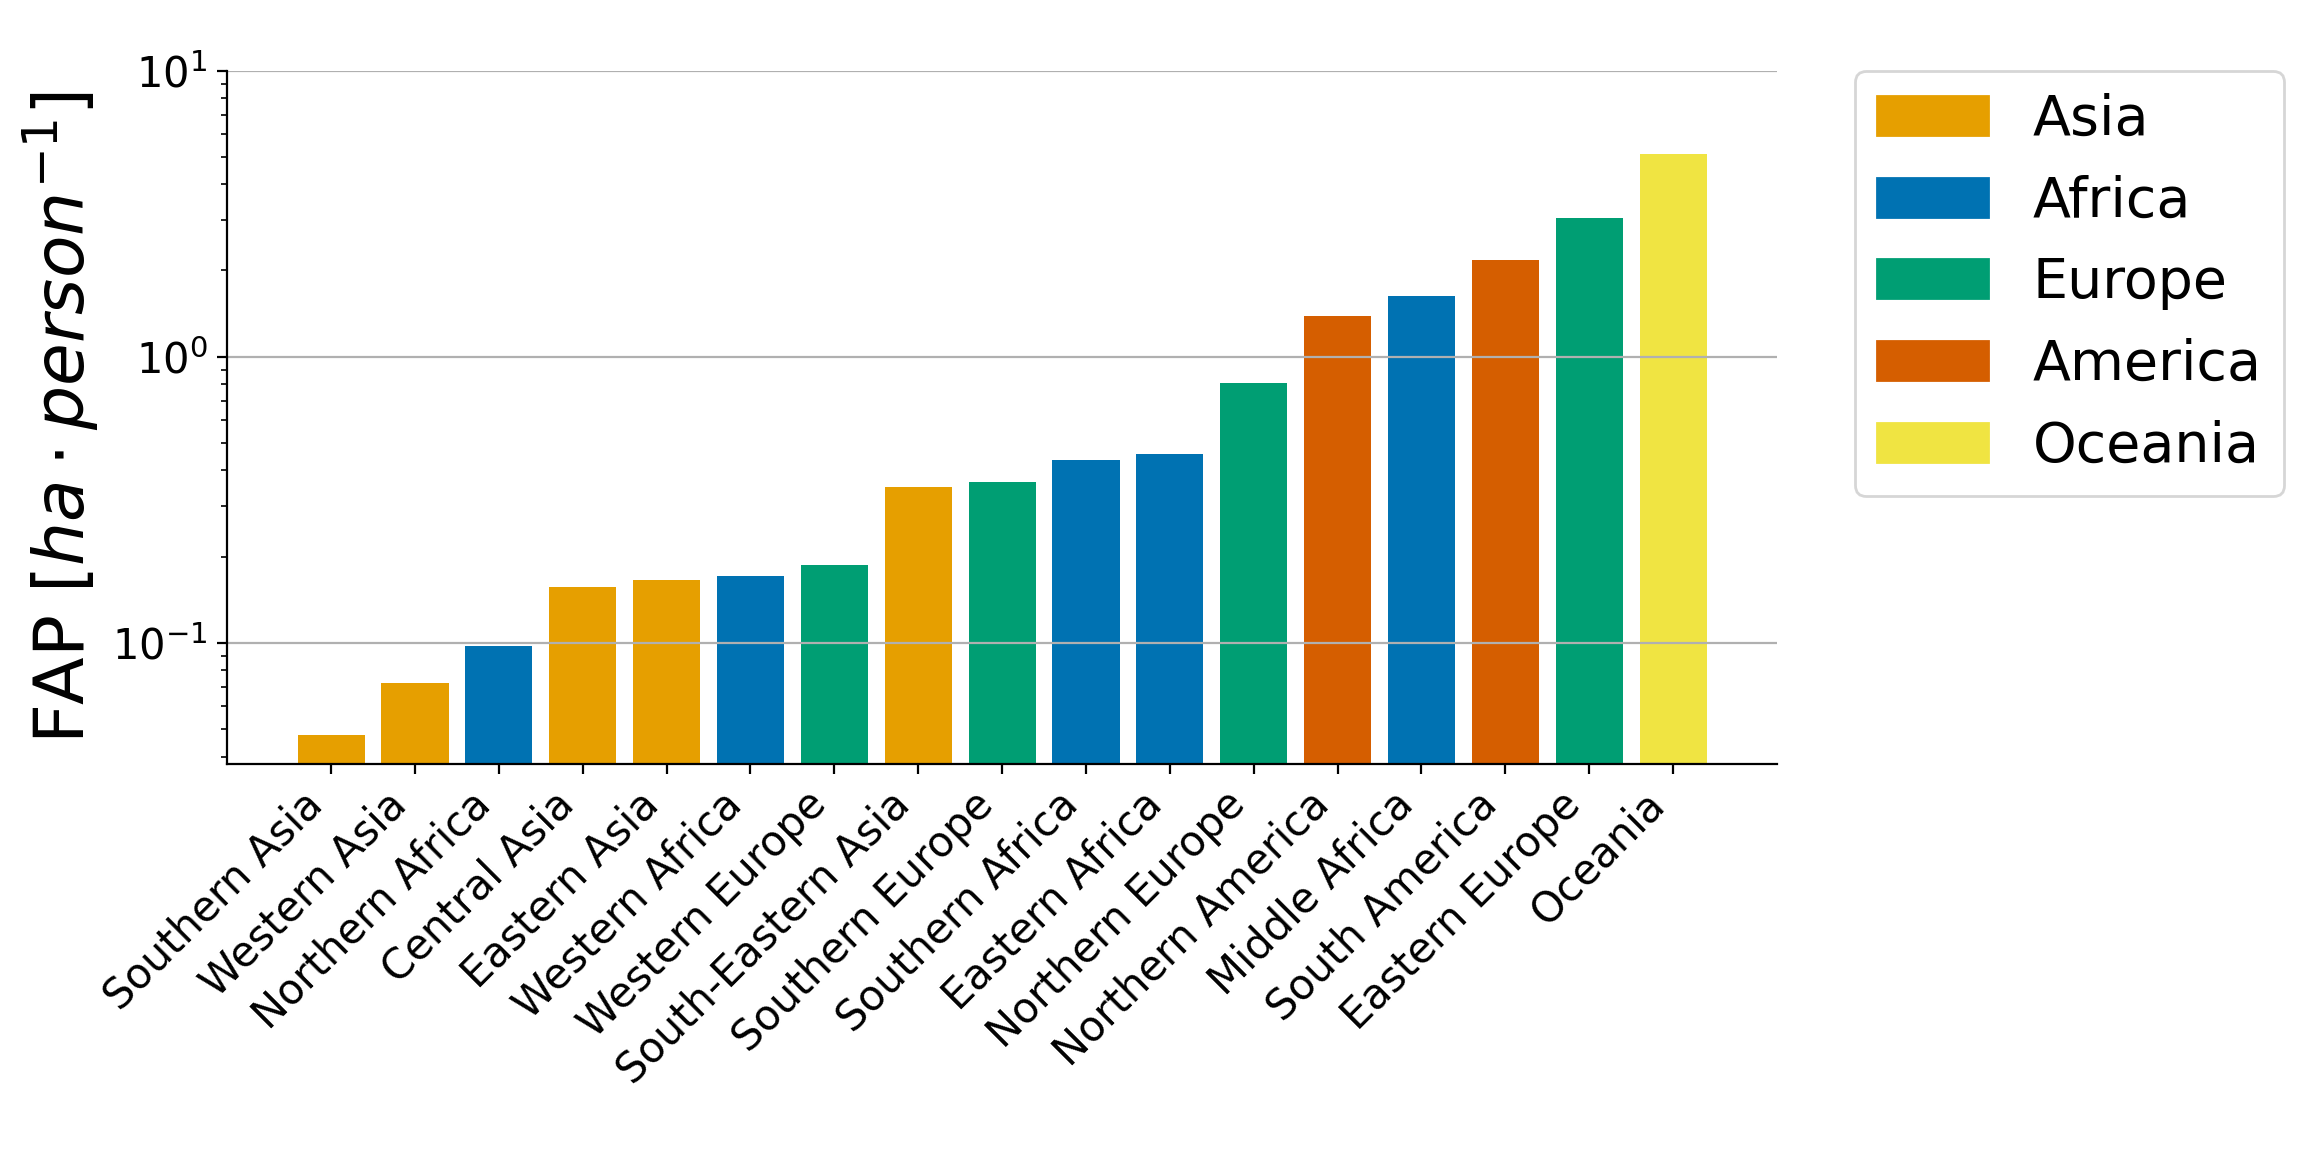

In [33]:
# Plotting the bar plot
f, ax = plt.subplots(figsize=(10, 4.5))
ax = set_font(ax, 15)
plt.bar(dff['region'], dff['FAPh'], color=colors)
# Adding labels and title
plt.xlabel(' ')
plt.ylabel('FAP '+r'$[ha \cdot person^{-1}]$', size=25)
plt.title(' ', size=16)
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Creating legend patches
patches = [mpatches.Patch(color=color, label=continent) for continent, color in CONTINENT_COLORS.items()]
# Adding the legend outside the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.xticks(rotation=45, ha='right');
ax.set_yscale('log')
ax.set_ylim([0, 10])

In [34]:
# Save Figure 1C
fout = '../Figures/Figure2B_new.pdf'
f.savefig(fout, dpi=300, bbox_inches='tight')